In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import cv2
import timeit
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow import keras
import tensorflow as tf
from keras import Model
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD,Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from tensorflow.keras.layers import MaxPooling2D,BatchNormalization,Conv2D,Dense,Activation,Conv2DTranspose,Input
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D,AveragePooling2D,GlobalAveragePooling2D,Concatenate

In [ ]:
def num (image) :

    val = 0

    for i in range(len(image)) :
        if image[i] == '(' :
            while True :
                i += 1
                if image[i] == ')' :
                    break
                val = (val*10) + int(image[i])
            break

    return val

In [ ]:
#x for images
#y for masks
#t for target"label"
X_b, y_b = np.zeros((437, 128, 128, 1)), np.zeros((437, 128, 128, 1))
X_n, y_n = np.zeros((133, 128, 128, 1)), np.zeros((133, 128, 128, 1))
X_m, y_m= np.zeros((210, 128, 128, 1)), np.zeros((210, 128, 128, 1))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Uni/tmu/dl/bcancer/Dataset_BUSI_with_GT/'

In [ ]:
for i, tumor_type in enumerate(os.listdir(path)) :
    for image in os.listdir(path+tumor_type+'/') :
        p = os.path.join(path+tumor_type, image)
        img = cv2.imread(p,cv2.IMREAD_GRAYSCALE)           # read image as  grayscale

        if image[-5] == ')' :

            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)

            if image[0] == 'b' :
                X_b[num(image)-1]+= img_to_array(pil_img)  # If image is real add it
            if image[0] == 'n' :                           # to X as benign , normal
                X_n[num(image)-1]+= img_to_array(pil_img)  # or malignant.
            if image[0] == 'm' :
                X_m[num(image)-1]+= img_to_array(pil_img)
        else :
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)

            if image[0] == 'b' :
                y_b[num(image)-1]+= img_to_array(pil_img)  # Similarly add the target
            if image[0] == 'n' :                           # mask to y.
                y_n[num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                y_m[num(image)-1]+= img_to_array(pil_img)

In [ ]:
X = np.concatenate((X_b, X_n, X_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)

In [ ]:
print(X.shape)
print(y.shape)

(780, 128, 128, 1)
(780, 128, 128, 1)


In [ ]:
def convertToOneChannel(img):
   im=np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
   i=cv2.resize(im, (128, 128))
   return i

In [ ]:
 def convertToThreeChannel(img):
       b_np= np.array(img)
       g_np= np.array(img)
       r_np= np.array(img)
       final_img = np.dstack([b_np, g_np, r_np]).astype(np.uint8)
       return np.array(final_img)

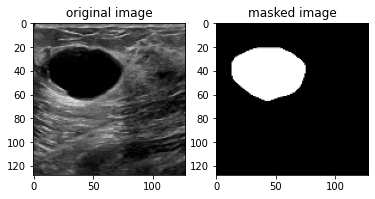

In [ ]:
img=convertToThreeChannel(X[25])
mask=convertToThreeChannel(y[25])
plt.figure
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(mask)
plt.title("masked image")
plt.show()

In [ ]:
actual=[]
mask=[]
for i in X:
  horizontal_flip = cv2.flip(i, 1)
  vertical_horizontal_flip = cv2.flip(i, -1)
  imagerotate = cv2.rotate(i, cv2.ROTATE_180)
  imagerotate1 = cv2.rotate(i, cv2.ROTATE_90_COUNTERCLOCKWISE)
  imagerotate2 = cv2.rotate(i, cv2.ROTATE_90_CLOCKWISE)
  actual.append(horizontal_flip)
  actual.append(vertical_horizontal_flip)
  actual.append(imagerotate)
  actual.append(imagerotate1)
  actual.append(imagerotate2)


for j in y:
    horizontal_flip_mask = cv2.flip(j, 1)
    vertical_horizontal_flip_mask = cv2.flip(j, -1)
    imagerotate_mask1 = cv2.rotate(j, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imagerotate_mask = cv2.rotate(j, cv2.ROTATE_180)
    imagerotate_mask2 = cv2.rotate(j, cv2.ROTATE_90_CLOCKWISE)
    mask.append(horizontal_flip_mask)
    mask.append(vertical_horizontal_flip_mask)
    mask.append(imagerotate_mask)
    mask.append(imagerotate_mask1)
    mask.append(imagerotate_mask2)

In [ ]:
mask=np.array(mask)
actual=np.array(actual)
print(actual.shape)
print(mask.shape)

(3900, 128, 128)
(3900, 128, 128)


In [ ]:
actual=actual/255
mask=mask/255
print(mask.max())
print(mask.min())

2.0
0.0


In [ ]:
mask[mask > 1.0] = 1.0

In [ ]:
print(mask.max())
print(mask.min())

1.0
0.0


In [ ]:
mask=np.array(mask)
actual=np.array(actual)
print(actual.shape)
print(mask.shape)

(3900, 128, 128)
(3900, 128, 128)


In [ ]:
t1=np.full(2185,1)
t2=np.full(665,0)
t3=np.full(1050,2)
T=np.concatenate((t1, t2, t3), axis = 0)
T=np.array(T)

In [ ]:
print(T.shape)

(3900,)


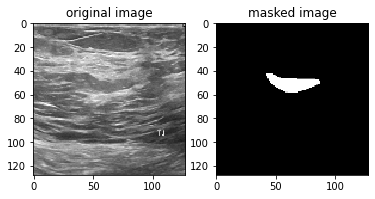

In [ ]:
plt.figure
plt.subplot(1,2,1)
plt.imshow(actual[1000],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(mask[1000],interpolation='nearest',cmap='gray')
plt.title("masked image")
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(actual, mask, test_size = 0.35, random_state = 1)

In [ ]:
actual1=[]
for i in actual:
  actual1.append(convertToThreeChannel(i) )
mask1=[]
for i in mask:
  mask1.append(convertToThreeChannel(i) )
actual1=np.array(actual1)
mask1=np.array(mask1)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(2535, 128, 128)
(1365, 128, 128)


In [ ]:
inply = Input((128, 128, 1,))

conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(inply)
conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv1)
pool1 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv1)
drop1 = Dropout(0.2)(pool1)

conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(drop1)
conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv2)
pool2 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv2)
drop2 = Dropout(0.2)(pool2)

conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(drop2)
conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv3)
pool3 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv3)
drop3 = Dropout(0.2)(pool3)

conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(drop3)
conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv4)
pool4 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv4)
drop4 = Dropout(0.2)(pool4)

In [ ]:
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(drop4)
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(convm)

In [ ]:
tran5 = Conv2DTranspose(2**9, (2,2), strides = 2, padding = 'valid', activation = 'relu')(convm)
conc5 = Concatenate()([tran5, conv4])
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conc5)
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv5)
drop5 = Dropout(0.1)(conv5)

tran6 = Conv2DTranspose(2**8, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop5)
conc6 = Concatenate()([tran6, conv3])
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conc6)
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv6)
drop6 = Dropout(0.1)(conv6)

tran7 = Conv2DTranspose(2**7, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop6)
conc7 = Concatenate()([tran7, conv2])
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conc7)
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv7)
drop7 = Dropout(0.1)(conv7)

tran8 = Conv2DTranspose(2**6, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop7)
conc8 = Concatenate()([tran8, conv1])
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conc8)
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv8)
drop8 = Dropout(0.1)(conv8)

In [ ]:
outly = Conv2D(2**0, (1,1), activation = 'relu', padding = 'same')(drop8)
model = Model(inputs = inply, outputs = outly, name = 'U-net')

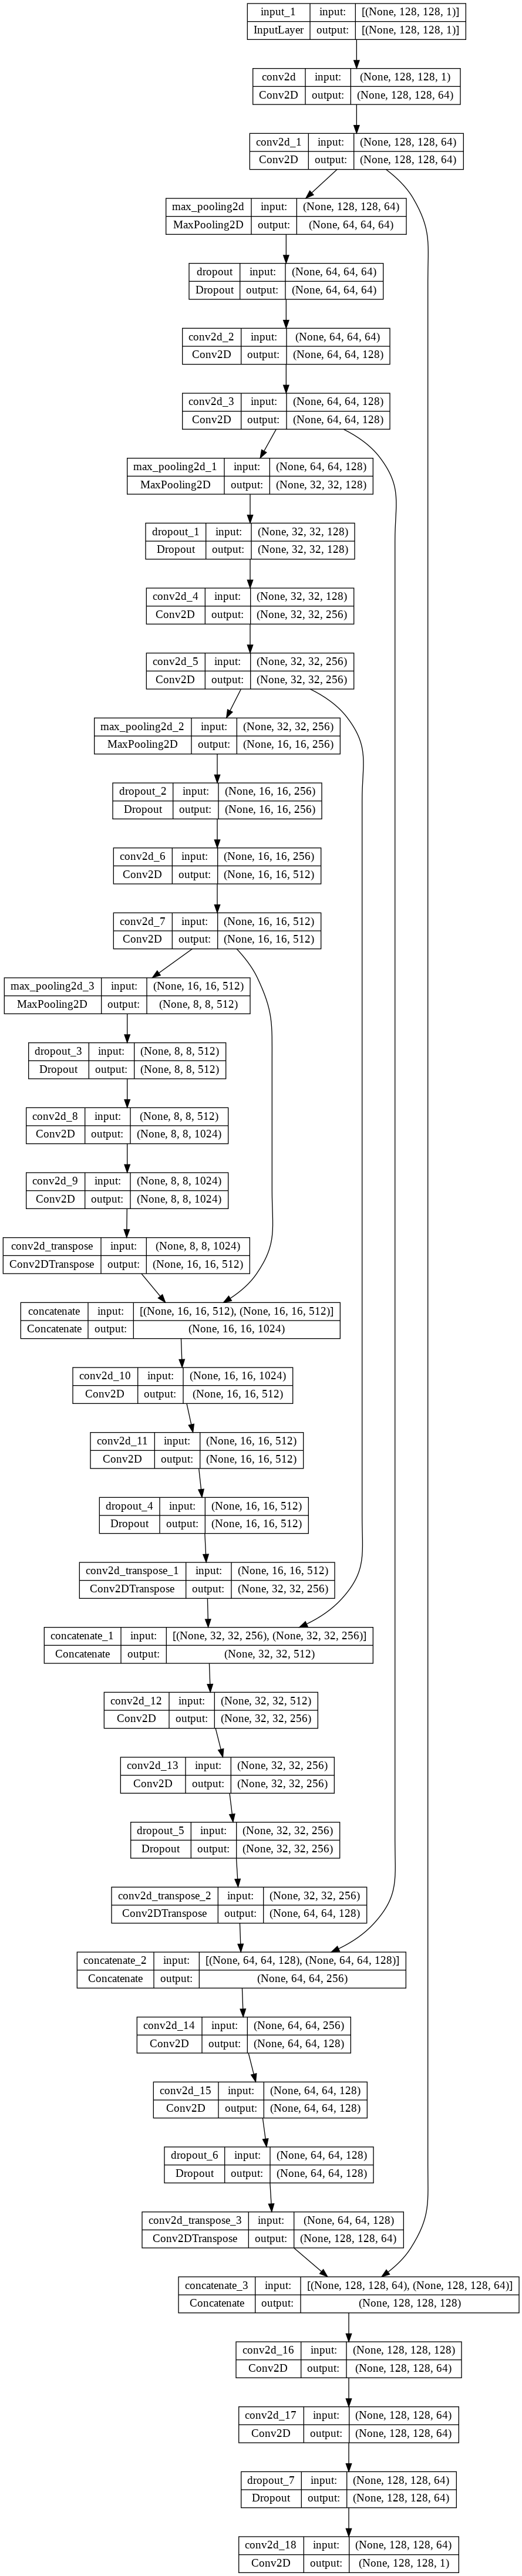

In [ ]:
keras.utils.plot_model(model, './model_plot.png', show_shapes = True)

In [ ]:
from keras.metrics import MeanIoU

In [ ]:
model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate = 0.00005),metrics=['acc'])
print(model.summary())

Model: "U-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
from keras.callbacks import ModelCheckpoint

In [ ]:
checkp = ModelCheckpoint('./unet_model.h5', monitor = 'accuracy', save_best_only = True, verbose = 1)

In [ ]:
history = model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data = (X_test, y_test), callbacks = [checkp])

Epoch 1/50
80/80 [==============================] - ETA: 0s - loss: 0.0442 - acc: 0.9419

80/80 [==============================] - 40s 499ms/step - loss: 0.0442 - acc: 0.9419 - val_loss: 0.0438 - val_acc: 0.9404
Epoch 2/50
80/80 [==============================] - ETA: 0s - loss: 0.0419 - acc: 0.9451

80/80 [==============================] - 39s 493ms/step - loss: 0.0419 - acc: 0.9451 - val_loss: 0.0414 - val_acc: 0.9437
Epoch 3/50
80/80 [==============================] - ETA: 0s - loss: 0.0411 - acc: 0.9466

80/80 [==============================] - 39s 494ms/step - loss: 0.0411 - acc: 0.9466 - val_loss: 0.0422 - val_acc: 0.9414
Epoch 4/50
80/80 [==============================] - ETA: 0s - loss: 0.0383 - acc: 0.9502

80/80 [==============================] - 39s 494ms/step - loss: 0.0383 - acc: 0.9502 - val_loss: 0.0360 - val_acc: 0.9538
Epoch 5/50
80/80 [==============================] - ETA: 0s - loss: 0.0363 - acc: 0.9532

80/80 [==============================] - 39s 493ms/step - loss: 0.0363 - acc: 0.9532 - val_loss: 0.0338 - val_acc: 0.9571
Epoch 6/50
80/80 [==============================] - ETA: 0s - loss: 0.0343 - acc: 0.9558

80/80 [==============================] - 39s 493ms/step - loss: 0.0343 - acc: 0.9558 - val_loss: 0.0337 - val_acc: 0.9569
Epoch 7/50
80/80 [==============================] - ETA: 0s - loss: 0.0320 - acc: 0.9591

80/80 [==============================] - 39s 493ms/step - loss: 0.0320 - acc: 0.9591 - val_loss: 0.0320 - val_acc: 0.9590
Epoch 8/50
80/80 [==============================] - ETA: 0s - loss: 0.0306 - acc: 0.9607

80/80 [==============================] - 39s 494ms/step - loss: 0.0306 - acc: 0.9607 - val_loss: 0.0294 - val_acc: 0.9623
Epoch 9/50
80/80 [==============================] - ETA: 0s - loss: 0.0291 - acc: 0.9627

80/80 [==============================] - 44s 547ms/step - loss: 0.0291 - acc: 0.9627 - val_loss: 0.0281 - val_acc: 0.9638
Epoch 10/50
80/80 [==============================] - ETA: 0s - loss: 0.0269 - acc: 0.9656

80/80 [==============================] - 40s 494ms/step - loss: 0.0269 - acc: 0.9656 - val_loss: 0.0277 - val_acc: 0.9640
Epoch 11/50
80/80 [==============================] - ETA: 0s - loss: 0.0258 - acc: 0.9669

80/80 [==============================] - 39s 493ms/step - loss: 0.0258 - acc: 0.9669 - val_loss: 0.0292 - val_acc: 0.9630
Epoch 12/50
80/80 [==============================] - ETA: 0s - loss: 0.0248 - acc: 0.9683

80/80 [==============================] - 39s 492ms/step - loss: 0.0248 - acc: 0.9683 - val_loss: 0.0262 - val_acc: 0.9662
Epoch 13/50
80/80 [==============================] - ETA: 0s - loss: 0.0230 - acc: 0.9704

80/80 [==============================] - 39s 492ms/step - loss: 0.0230 - acc: 0.9704 - val_loss: 0.0267 - val_acc: 0.9658
Epoch 14/50
80/80 [==============================] - ETA: 0s - loss: 0.0222 - acc: 0.9714

80/80 [==============================] - 39s 493ms/step - loss: 0.0222 - acc: 0.9714 - val_loss: 0.0267 - val_acc: 0.9658
Epoch 15/50
80/80 [==============================] - ETA: 0s - loss: 0.0217 - acc: 0.9719

80/80 [==============================] - 39s 493ms/step - loss: 0.0217 - acc: 0.9719 - val_loss: 0.0256 - val_acc: 0.9669
Epoch 16/50
80/80 [==============================] - ETA: 0s - loss: 0.0214 - acc: 0.9722

80/80 [==============================] - 39s 492ms/step - loss: 0.0214 - acc: 0.9722 - val_loss: 0.0275 - val_acc: 0.9646
Epoch 17/50
80/80 [==============================] - ETA: 0s - loss: 0.0209 - acc: 0.9728

80/80 [==============================] - 39s 492ms/step - loss: 0.0209 - acc: 0.9728 - val_loss: 0.0243 - val_acc: 0.9684
Epoch 18/50
80/80 [==============================] - ETA: 0s - loss: 0.0189 - acc: 0.9755

80/80 [==============================] - 39s 492ms/step - loss: 0.0189 - acc: 0.9755 - val_loss: 0.0239 - val_acc: 0.9695
Epoch 19/50
80/80 [==============================] - ETA: 0s - loss: 0.0186 - acc: 0.9756

80/80 [==============================] - 39s 491ms/step - loss: 0.0186 - acc: 0.9756 - val_loss: 0.0245 - val_acc: 0.9690
Epoch 20/50
80/80 [==============================] - ETA: 0s - loss: 0.0180 - acc: 0.9763

80/80 [==============================] - 39s 491ms/step - loss: 0.0180 - acc: 0.9763 - val_loss: 0.0230 - val_acc: 0.9704
Epoch 21/50
80/80 [==============================] - ETA: 0s - loss: 0.0174 - acc: 0.9770

80/80 [==============================] - 39s 490ms/step - loss: 0.0174 - acc: 0.9770 - val_loss: 0.0237 - val_acc: 0.9694
Epoch 22/50
80/80 [==============================] - ETA: 0s - loss: 0.0162 - acc: 0.9785

80/80 [==============================] - 39s 489ms/step - loss: 0.0162 - acc: 0.9785 - val_loss: 0.0231 - val_acc: 0.9706
Epoch 23/50
80/80 [==============================] - ETA: 0s - loss: 0.0152 - acc: 0.9797

80/80 [==============================] - 39s 488ms/step - loss: 0.0152 - acc: 0.9797 - val_loss: 0.0228 - val_acc: 0.9705
Epoch 24/50
80/80 [==============================] - ETA: 0s - loss: 0.0143 - acc: 0.9807

80/80 [==============================] - 39s 488ms/step - loss: 0.0143 - acc: 0.9807 - val_loss: 0.0229 - val_acc: 0.9701
Epoch 25/50
80/80 [==============================] - ETA: 0s - loss: 0.0142 - acc: 0.9807

80/80 [==============================] - 39s 490ms/step - loss: 0.0142 - acc: 0.9807 - val_loss: 0.0225 - val_acc: 0.9714
Epoch 26/50
80/80 [==============================] - ETA: 0s - loss: 0.0134 - acc: 0.9816

80/80 [==============================] - 39s 490ms/step - loss: 0.0134 - acc: 0.9816 - val_loss: 0.0226 - val_acc: 0.9711
Epoch 27/50
80/80 [==============================] - ETA: 0s - loss: 0.0129 - acc: 0.9822

80/80 [==============================] - 39s 489ms/step - loss: 0.0129 - acc: 0.9822 - val_loss: 0.0227 - val_acc: 0.9712
Epoch 28/50
80/80 [==============================] - ETA: 0s - loss: 0.0124 - acc: 0.9828

80/80 [==============================] - 39s 489ms/step - loss: 0.0124 - acc: 0.9828 - val_loss: 0.0225 - val_acc: 0.9708
Epoch 29/50
80/80 [==============================] - ETA: 0s - loss: 0.0124 - acc: 0.9827

80/80 [==============================] - 39s 489ms/step - loss: 0.0124 - acc: 0.9827 - val_loss: 0.0223 - val_acc: 0.9719
Epoch 30/50
80/80 [==============================] - ETA: 0s - loss: 0.0116 - acc: 0.9839

80/80 [==============================] - 39s 490ms/step - loss: 0.0116 - acc: 0.9839 - val_loss: 0.0221 - val_acc: 0.9720
Epoch 31/50
80/80 [==============================] - ETA: 0s - loss: 0.0108 - acc: 0.9848

80/80 [==============================] - 39s 489ms/step - loss: 0.0108 - acc: 0.9848 - val_loss: 0.0228 - val_acc: 0.9718
Epoch 32/50
80/80 [==============================] - ETA: 0s - loss: 0.0104 - acc: 0.9853

80/80 [==============================] - 39s 489ms/step - loss: 0.0104 - acc: 0.9853 - val_loss: 0.0215 - val_acc: 0.9725
Epoch 33/50
80/80 [==============================] - ETA: 0s - loss: 0.0100 - acc: 0.9858

80/80 [==============================] - 39s 489ms/step - loss: 0.0100 - acc: 0.9858 - val_loss: 0.0216 - val_acc: 0.9729
Epoch 34/50
80/80 [==============================] - ETA: 0s - loss: 0.0096 - acc: 0.9863

80/80 [==============================] - 39s 488ms/step - loss: 0.0096 - acc: 0.9863 - val_loss: 0.0228 - val_acc: 0.9711
Epoch 35/50
80/80 [==============================] - ETA: 0s - loss: 0.0093 - acc: 0.9866

80/80 [==============================] - 39s 488ms/step - loss: 0.0093 - acc: 0.9866 - val_loss: 0.0220 - val_acc: 0.9727
Epoch 36/50
80/80 [==============================] - ETA: 0s - loss: 0.0091 - acc: 0.9869

80/80 [==============================] - 39s 488ms/step - loss: 0.0091 - acc: 0.9869 - val_loss: 0.0217 - val_acc: 0.9727
Epoch 37/50
80/80 [==============================] - ETA: 0s - loss: 0.0089 - acc: 0.9871

80/80 [==============================] - 39s 488ms/step - loss: 0.0089 - acc: 0.9871 - val_loss: 0.0223 - val_acc: 0.9725
Epoch 38/50
80/80 [==============================] - ETA: 0s - loss: 0.0087 - acc: 0.9874

80/80 [==============================] - 39s 486ms/step - loss: 0.0087 - acc: 0.9874 - val_loss: 0.0219 - val_acc: 0.9728
Epoch 39/50
80/80 [==============================] - ETA: 0s - loss: 0.0087 - acc: 0.9874

80/80 [==============================] - 39s 483ms/step - loss: 0.0087 - acc: 0.9874 - val_loss: 0.0219 - val_acc: 0.9729
Epoch 40/50
80/80 [==============================] - ETA: 0s - loss: 0.0082 - acc: 0.9880

80/80 [==============================] - 38s 480ms/step - loss: 0.0082 - acc: 0.9880 - val_loss: 0.0216 - val_acc: 0.9728
Epoch 41/50
80/80 [==============================] - ETA: 0s - loss: 0.0081 - acc: 0.9882

80/80 [==============================] - 38s 479ms/step - loss: 0.0081 - acc: 0.9882 - val_loss: 0.0216 - val_acc: 0.9729
Epoch 42/50
80/80 [==============================] - ETA: 0s - loss: 0.0078 - acc: 0.9887

80/80 [==============================] - 38s 478ms/step - loss: 0.0078 - acc: 0.9887 - val_loss: 0.0218 - val_acc: 0.9731
Epoch 43/50
80/80 [==============================] - ETA: 0s - loss: 0.0078 - acc: 0.9886

80/80 [==============================] - 38s 477ms/step - loss: 0.0078 - acc: 0.9886 - val_loss: 0.0224 - val_acc: 0.9726
Epoch 44/50
80/80 [==============================] - ETA: 0s - loss: 0.0078 - acc: 0.9886

80/80 [==============================] - 38s 477ms/step - loss: 0.0078 - acc: 0.9886 - val_loss: 0.0218 - val_acc: 0.9730
Epoch 45/50
80/80 [==============================] - ETA: 0s - loss: 0.0075 - acc: 0.9889

80/80 [==============================] - 38s 477ms/step - loss: 0.0075 - acc: 0.9889 - val_loss: 0.0223 - val_acc: 0.9728
Epoch 46/50
80/80 [==============================] - ETA: 0s - loss: 0.0072 - acc: 0.9894

80/80 [==============================] - 38s 477ms/step - loss: 0.0072 - acc: 0.9894 - val_loss: 0.0217 - val_acc: 0.9733
Epoch 47/50
80/80 [==============================] - ETA: 0s - loss: 0.0070 - acc: 0.9896

80/80 [==============================] - 38s 477ms/step - loss: 0.0070 - acc: 0.9896 - val_loss: 0.0219 - val_acc: 0.9732
Epoch 48/50
80/80 [==============================] - ETA: 0s - loss: 0.0069 - acc: 0.9898

80/80 [==============================] - 38s 477ms/step - loss: 0.0069 - acc: 0.9898 - val_loss: 0.0218 - val_acc: 0.9734
Epoch 49/50
80/80 [==============================] - ETA: 0s - loss: 0.0069 - acc: 0.9898

80/80 [==============================] - 38s 476ms/step - loss: 0.0069 - acc: 0.9898 - val_loss: 0.0220 - val_acc: 0.9733
Epoch 50/50
80/80 [==============================] - ETA: 0s - loss: 0.0067 - acc: 0.9900

80/80 [==============================] - 38s 476ms/step - loss: 0.0067 - acc: 0.9900 - val_loss: 0.0220 - val_acc: 0.9732


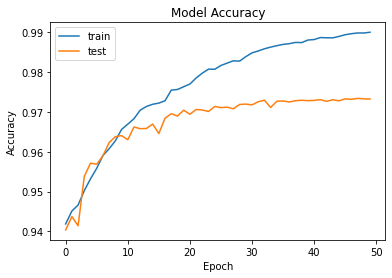

In [ ]:
# dictionary keys seems to have changed in version 2
k = ''
if 'accuracy' in history.history :
    k = 'accuracy'

if 'acc' in history.history :
    k = 'acc'

if k != '' :
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

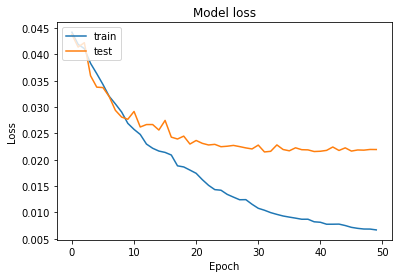

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 1)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

43/43 [==============================] - 6s 129ms/step - loss: 0.0220 - acc: 0.9732
Test loss: 0.02195075713098049
Test accuracy: 97.32337594032288


In [ ]:
model.save("finalunet.h5")

In [ ]:
def imgpredicting(img):
 x=[]
 x.append(img)
 x=np.array(x)
 output=model.predict(x)
 #print(output)
 output=np.array(output)
 output.shape
 array = np.reshape(output[0], (128, 128))
 print(array.shape)
 return array

1/1 [==============================] - 1s 1s/step
(128, 128)


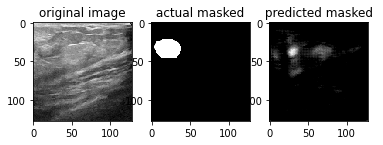

In [ ]:
plt.figure
plt.subplot(1,3,1)
plt.imshow(actual[300],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(mask[300],interpolation='nearest',cmap='gray')
plt.title(" actual masked ")
plt.subplot(1,3,3)
plt.imshow(imgpredicting(actual[300]),interpolation='nearest',cmap='gray')
plt.title(" predicted masked ")
plt.show()

1/1 [==============================] - 0s 18ms/step
(128, 128)


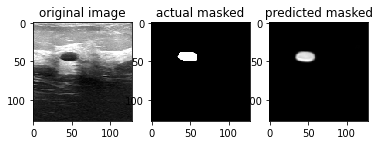

In [ ]:
plt.figure
plt.subplot(1,3,1)
plt.imshow(actual[550],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(mask[550],interpolation='nearest',cmap='gray')
plt.title(" actual masked ")
plt.subplot(1,3,3)
plt.imshow(imgpredicting(actual[550]),interpolation='nearest',cmap='gray')
plt.title(" predicted masked ")
plt.show()

1/1 [==============================] - 0s 18ms/step
(128, 128)


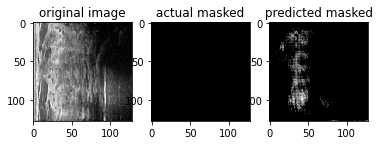

In [ ]:
plt.figure
plt.subplot(1,3,1)
plt.imshow(actual[2488],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(mask[2488],interpolation='nearest',cmap='gray')
plt.title(" actual masked ")
plt.subplot(1,3,3)
plt.imshow(imgpredicting(actual[2488]),interpolation='nearest',cmap='gray')
plt.title(" predicted masked ")
plt.show()

1/1 [==============================] - 0s 18ms/step
(128, 128)


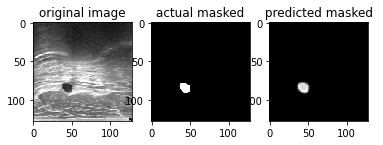

In [ ]:
plt.figure
plt.subplot(1,3,1)
plt.imshow(actual[752],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(mask[752],interpolation='nearest',cmap='gray')
plt.title(" actual masked ")
plt.subplot(1,3,3)
plt.imshow(imgpredicting(actual[752]),interpolation='nearest',cmap='gray')
plt.title(" predicted masked ")
plt.show()

1/1 [==============================] - 0s 33ms/step
(128, 128)


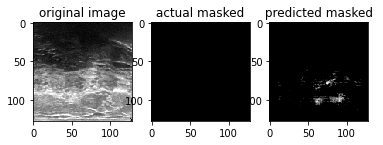

In [ ]:
plt.figure
plt.subplot(1,3,1)
plt.imshow(actual[2256],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(mask[2256],interpolation='nearest',cmap='gray')
plt.title(" actual masked ")
plt.subplot(1,3,3)
plt.imshow(imgpredicting(actual[2256]),interpolation='nearest',cmap='gray')
plt.title(" predicted masked ")
plt.show()